## Homework #4. Exploratory Data Analysis
#### Author: `Markiian Mandzak`
#### Total time spent on h/w (in minutes): ~720min

The original propaganda dataset by Kate Burovova should be already extracted into directory `../data/channels`


In [1]:
import os
import re
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from textblob import TextBlob
from tqdm import tqdm
from typing import Optional
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from langid.langid import LanguageIdentifier, model
import langcodes 
import numbers

def extract_reactions(reaction_str):
    if pd.isna(reaction_str):
        return {}
    
    pattern = re.compile(r"reaction='(.*?)', count=(\d+)")
    matches = pattern.findall(reaction_str)
    
    reaction_dict = {}
    for emoji, count in matches:
        reaction_dict[emoji] = int(count)
    
    return reaction_dict

def add_emoji_columns(df):
    df['parsed_reactions'] = df['reactions'].apply(extract_reactions)
    reactions_df = df['parsed_reactions'].apply(pd.Series).fillna(0)
    return pd.concat([df, reactions_df], axis=1)

nltk.download('stopwords')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
alt.data_transformers.disable_max_rows()

DATA_PATH = os.path.join('data')
CHANNELS_PATH = os.path.join(DATA_PATH, 'channels')
LOAD_MERGED = True
SAMPLE_FRAC = 0.02

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/markson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def load_channel(channel_name):
    channel_path = os.path.join(CHANNELS_PATH, channel_name)
    return pd.read_csv(channel_path, parse_dates=['date'], low_memory=False)

if not LOAD_MERGED:
    channels = {}
    channel_filenames = os.listdir(CHANNELS_PATH)
    num_files = len(channel_filenames)
    with tqdm(total=num_files, desc='Processing channels') as pbar:
        for channel_filename in channel_filenames:
                pbar.set_postfix(file=channel_filename)
                pbar.update(1)
                
                df = load_channel(channel_filename)
                channel_name = channel_filename.split('.')[0]
                channels[channel_name] = df
    df = pd.concat(channels.values(), ignore_index=True)
    del channels
    df.to_parquet('../data/merged_channels.parquet')
    del df

In [ ]:
def auto_opt_pd_dtypes(df_: pd.DataFrame, inplace=False) -> Optional[pd.DataFrame]: # https://stackoverflow.com/questions/57856010/automatically-optimizing-pandas-dtypes
    """ Automatically downcast Number dtypes for minimal possible,
        will not touch other (datetime, str, object, etc)
        
        :param df_: dataframe
        :param inplace: if False, will return a copy of input dataset
        
        :return: `None` if `inplace=True` or dataframe if `inplace=False`
    """
    df = df_ if inplace else df_.copy()
        
    for col in df.columns:
        # integers
        if issubclass(df[col].dtypes.type, numbers.Integral):
            # unsigned integers
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            # signed integers
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')
        # other real numbers
        elif issubclass(df[col].dtypes.type, numbers.Real):
            df[col] = pd.to_numeric(df[col], downcast='float')
    
    if not inplace:
        return df

df = pd.read_parquet('../data/merged_channels.parquet', engine="pyarrow")
df = df.drop(columns='Unnamed: 0')
df = df.drop(columns='id').reset_index().rename(columns={'index': 'id'})
df['date_time'] = pd.to_datetime(df['date'])
df['date'] = df['date_time'].dt.date
df['hour'] = df['date_time'].dt.hour
df['views'] = df['views'].fillna(0).replace([np.inf, -np.inf], 0).astype(int)
df['to_id'] = df['to_id'].str.extract(r'(\d+)').fillna(0).astype(int)
df = auto_opt_pd_dtypes(df)
df

,id,date,views,reactions,to_id,fwd_from,message,type,duration,frw_from_title,frw_from_name,msg_entity,date_time,hour
0,0,2022-12-15,9914,"MessageReactions(results=[ReactionCount(reaction=ReactionEmoji(emoticon='👍'), count=263, chosen_order=None), ReactionCount(reaction=ReactionEmoji(emoticon='🔥'), count=20, chosen_order=None), ReactionCount(reaction=ReactionEmoji(emoticon='👎'), count=7, chosen_order=None)], min=False, can_see_list=False, recent_reactions=[])",1183570279,None,А трансляция тем временем идет. Подписывайтесь\n\nhttps://www.youtube.com/watch?v=4L7T3u7utSw,photo,NaN,None,None,None,2022-12-15 16:32:15+00:00,16
1,1,2022-12-15,29207,"MessageReactions(results=[ReactionCount(reaction=ReactionEmoji(emoticon='👍'), count=1176, chosen_order=None), ReactionCount(reaction=ReactionEmoji(emoticon='👎'), count=38, chosen_order=None), ReactionCount(reaction=ReactionEmoji(emoticon='🔥'), count=25, chosen_order=None), ReactionCount(reaction=ReactionEmoji(emoticon='😢'), count=12, chosen_order=None)], min=False, can_see_list=False, recent_reactions=[])",1183570279,None,"В России ещё есть те, кто способен возрождать национальную экономику, и даже сейчас это не поздно начать. МЭФ (не путать с ВЭФ и ПМЭФ!) объединяет таких экспертов как Глазьев, Бабкин и Дмитриева.\n\nЭто они незадолго до СВО призывали вернуть из-за рубежа 600 млрд долларов, это они предлагали обложить налогами процесс вывода денег из России и именно они указывали на все ошибки Набиуллиной с Силуановым, полагая, что экономика должна служить нашей стране, её населению и её культуре. \n\nПрисоединяйтесь к телеграм-каналу ""МЭФ. Экономика для людей"" — подписывайтесь и читайте.",photo,NaN,None,None,None,2022-12-15 15:00:03+00:00,15
2,2,2022-12-15,41058,"MessageReactions(results=[ReactionCount(reaction=ReactionEmoji(emoticon='👍'), count=2004, chosen_order=None), ReactionCount(reaction=ReactionEmoji(emoticon='🔥'), count=265, chosen_order=None), ReactionCount(reaction=ReactionEmoji(emoticon='👎'), count=5, chosen_order=None)], min=False, can_see_list=False, recent_reactions=[])",1183570279,None,"«Катаргейт» набирает обороты - Обвиняемая в коррупции Кайли дала показания против Жозепа Борреля. \n\nВице-президент Европарламента в отставке Ева Кайли дала показания против главы дипломатии Евросоюза Жозепа Борреля, обвинив его в причастности к коррупционному скандалу.\n\nКайли - на выход, Боррелю приготовиться.",text,NaN,None,None,None,2022-12-15 14:21:22+00:00,14
3,3,2022-12-15,40696,"MessageReactions(results=[ReactionCount(reaction=ReactionEmoji(emoticon='👍'), count=714, chosen_order=None), ReactionCount(reaction=ReactionEmoji(emoticon='🔥'), count=49, chosen_order=None), ReactionCount(reaction=ReactionEmoji(emoticon='👎'), count=31, chosen_order=None)], min=False, can_see_list=False, recent_reactions=[])",1183570279,"MessageFwdHeader(date=datetime.datetime(2022, 12, 15, 13, 0, 13, tzinfo=datetime.timezone.utc), imported=False, from_id=PeerChannel(channel_id=1259004764), from_name=None, channel_post=11537, post_author=None, saved_from_peer=None, saved_from_msg_id=None, psa_type=None)","🔥В гостях у @Metametrica побывали товарищи из украинского проекта МРІЯ - Тарас Незалежко, Дмитрий Василец и Тамир Шейх. \n\n🧠Ребята бьются за умы украинцев на вражеской территории развенчивая мифы и фейки укропропаганды и ЦИПСО. \n\nЧто в выпуске⁉️\n\n▪️Почему украинцев 30 лет натравливали на русских?\n\n▪️Каким будет будущее Украины?\n\n▪️Как украинцы могут сохранить себя в единстве с Россией?\n\n▪️Можно ли ждать появление нового «Богдана Хмельницкого»?\n\n▪️Как разваливали украинское государство на деньги Госдепа?\n\n▪️Как работает ЦИПСО и что с этим делать?\n\n▪️Ждет ли украинцев светлое будущее?\n\nЭто и не только в новом выпуске 👈!\n\nОбязательно поддержите @Metametrica подпиской!\n\nПОДПИШИСЬ НА МЕТАМЕТРИКУ!",photo,NaN,None,None,None,2022-12-15 13:08:35+00:00,13
4,4,2022-12-15,51690,"MessageReactions(results=[ReactionCount(reaction=ReactionEmoji(emoticon='👍'), count=1606, chosen_order=None), Reacti

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8108693 entries, 0 to 8108692
Data columns (total 14 columns):
 #   Column          Dtype              
---  ------          -----              
 0   id              uint32             
 1   date            object             
 2   views           uint32             
 3   reactions       object             
 4   to_id           uint32             
 5   fwd_from        object             
 6   message         object             
 7   type            object             
 8   duration        float32            
 9   frw_from_title  object             
 10  frw_from_name   object             
 11  msg_entity      object             
 12  date_time       datetime64[ns, UTC]
 13  hour            uint8              
dtypes: datetime64[ns, UTC](1), float32(1), object(8), uint32(3), uint8(1)
memory usage: 688.2+ MB


# 1. What is the distribution of messages by hour?

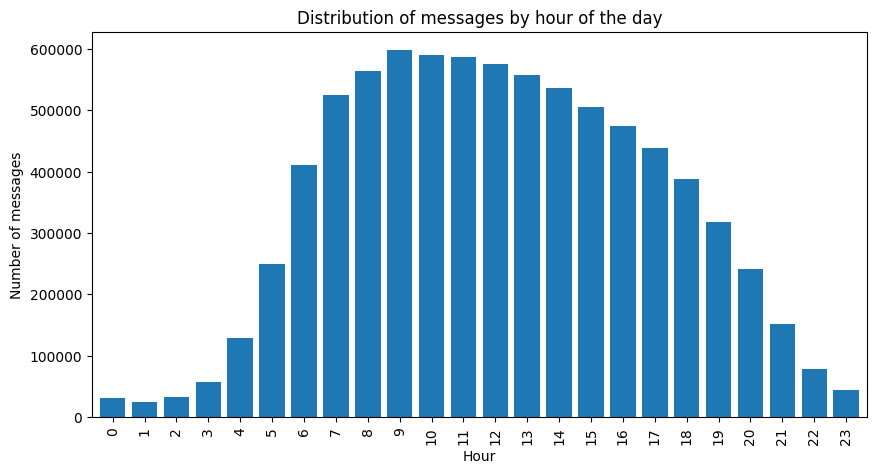

In [5]:
plt.figure(figsize=(10, 5))
df.groupby('hour').size().plot(kind='bar', width=0.8) 
plt.title('Distribution of messages by hour of the day')
plt.xlabel('Hour')
plt.ylabel('Number of messages')
plt.show()

# 2. What is the distribution of views by hour?

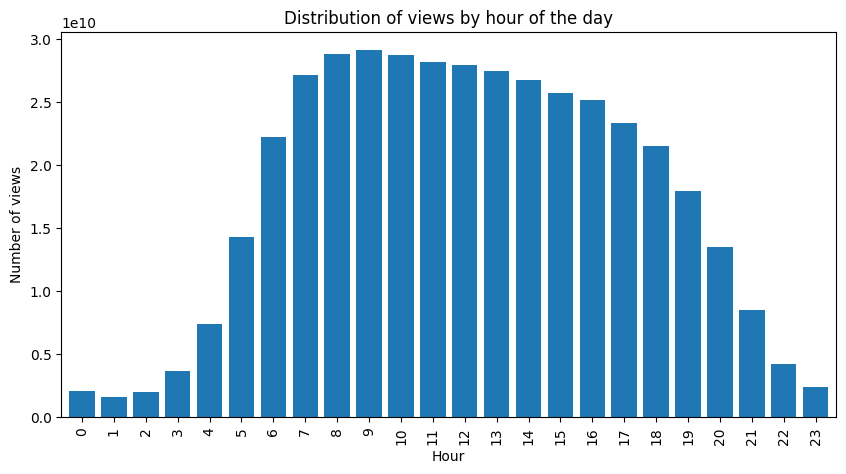

In [6]:
plt.figure(figsize=(10, 5))
df.groupby('hour')['views'].sum().plot(kind='bar', width=0.8)
plt.title('Distribution of views by hour of the day')
plt.xlabel('Hour')
plt.ylabel('Number of views')
plt.show()


# 3. What is the distribution of messages by day of week?

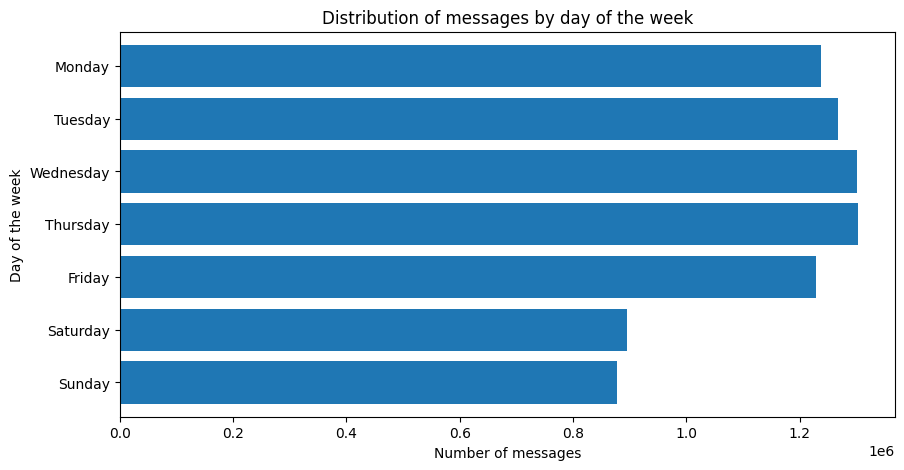

In [7]:
plt.figure(figsize=(10, 5))
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_order_reverse = days_order[::-1]
df.groupby(df['date_time'].dt.day_name()).size().reindex(days_order_reverse).plot(kind='barh', width=0.8)
plt.title('Distribution of messages by day of the week')
plt.xlabel('Number of messages')
plt.ylabel('Day of the week')
plt.show()

# 4. What is the distribution of views by day of week?

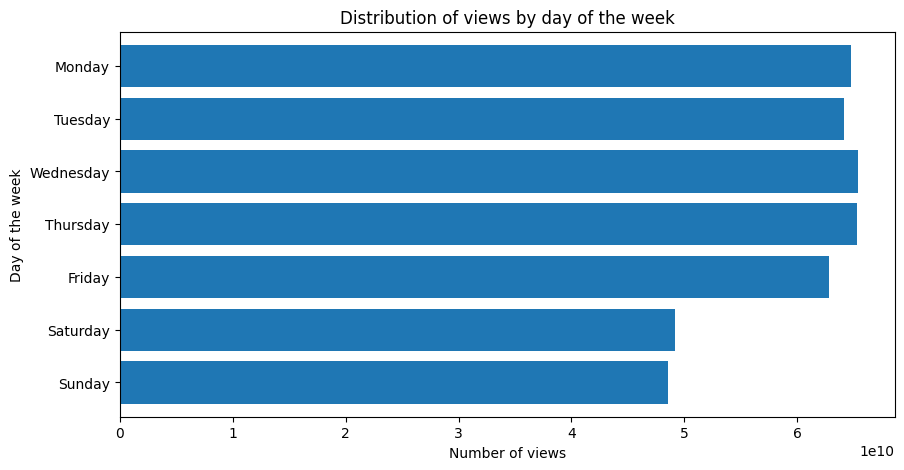

In [8]:
plt.figure(figsize=(10, 5))
df.groupby(df['date_time'].dt.day_name())['views'].sum().reindex(days_order_reverse).plot(kind='barh', width=0.8)
plt.title('Distribution of views by day of the week')
plt.xlabel('Number of views')
plt.ylabel('Day of the week')
plt.show()


# 5. What is the distirubution of messages by date?

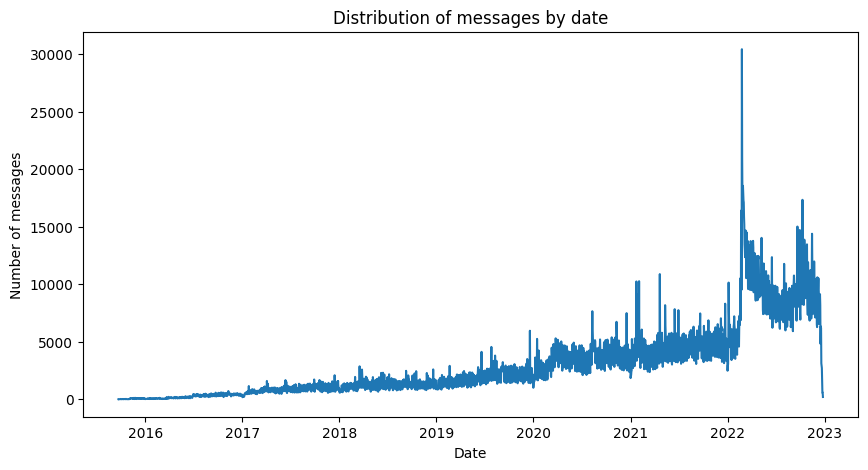

In [9]:
plt.figure(figsize=(10, 5))
df.groupby('date').size().plot()
plt.title('Distribution of messages by date')
plt.xlabel('Date')
plt.ylabel('Number of messages')
plt.show()

# 6. What is the distirubution of views by date?

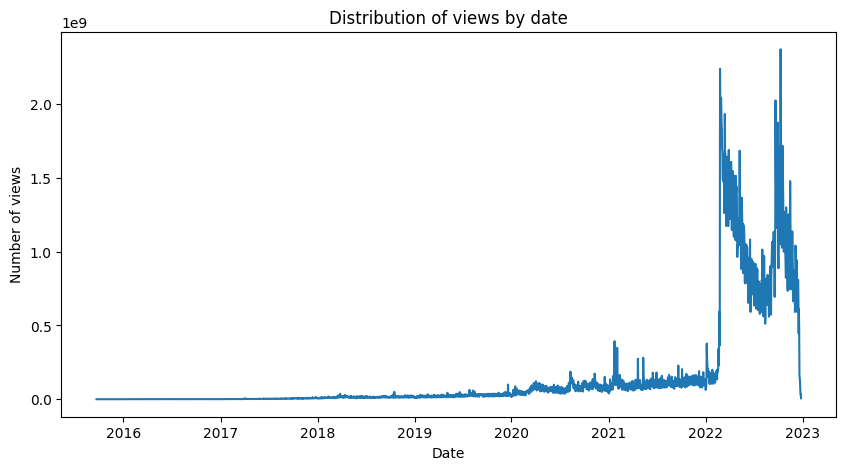

In [10]:
plt.figure(figsize=(10, 5))
df.groupby('date')['views'].sum().plot()
plt.title('Distribution of views by date')
plt.xlabel('Date')
plt.ylabel('Number of views')
plt.show()

# 7. Are there seasonal trends in message activity?

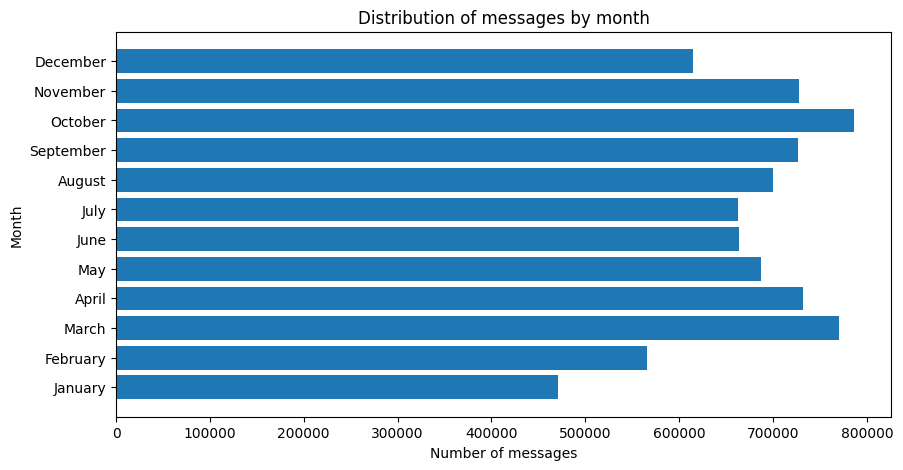

In [11]:
df_ = df.copy()
df_['month'] = df_['date_time'].dt.month
monthly_activity = df_.groupby('month').size().reset_index().rename(columns={0: 'count'})
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_activity['month'] = monthly_activity['month'].apply(lambda x: months[x-1])

plt.figure(figsize=(10, 5))
plt.barh(monthly_activity['month'], monthly_activity['count'])
plt.title('Distribution of messages by month')
plt.xlabel('Number of messages')
plt.ylabel('Month')
plt.show()

# 8. Are there seasonal trends in views activity?

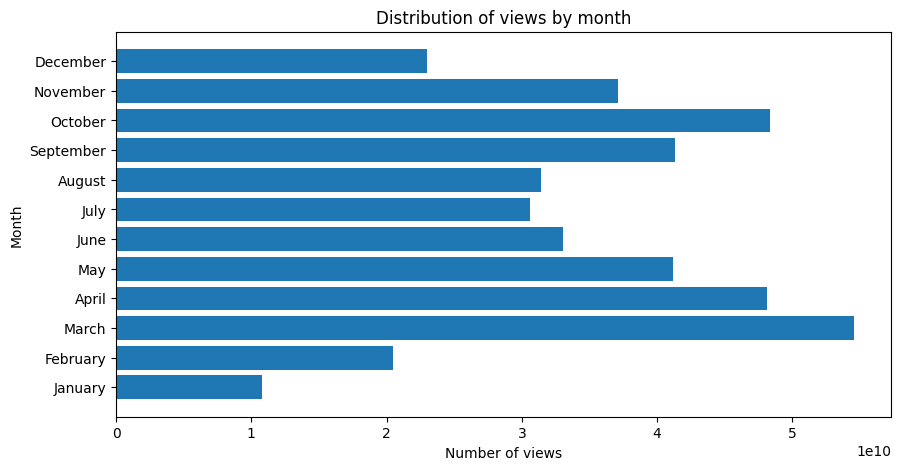

In [12]:
df_ = df.copy()
df_['month'] = df_['date_time'].dt.month
monthly_activity = df_.groupby('month')['views'].sum().reset_index().rename(columns={'views': 'count'})
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_activity['month'] = monthly_activity['month'].apply(lambda x: months[x-1])

plt.figure(figsize=(10, 5))
plt.barh(monthly_activity['month'], monthly_activity['count'])
plt.title('Distribution of views by month')
plt.xlabel('Number of views')
plt.ylabel('Month')
plt.show()

# 9. What percentage of posts have no reactions despite being viewed?

In [13]:
df_ = df[['views', 'reactions']].sample(frac=SAMPLE_FRAC).copy()
df_ = add_emoji_columns(df_)
df_['reaction_count'] = df_.iloc[:, 3:].sum(axis=1)
no_reaction_posts = df_[(df_['views'] > 0) & (df_['reaction_count'] == 0)].shape[0]
total_posts = df_[df_['views'] > 0].shape[0]
percentage_no_reactions = (no_reaction_posts / total_posts) * 100
print(f"Percentage of viewed posts without reactions: {percentage_no_reactions:.2f}%")

Percentage of viewed posts without reactions: 77.90%


# 10. What are the most common message sizes?

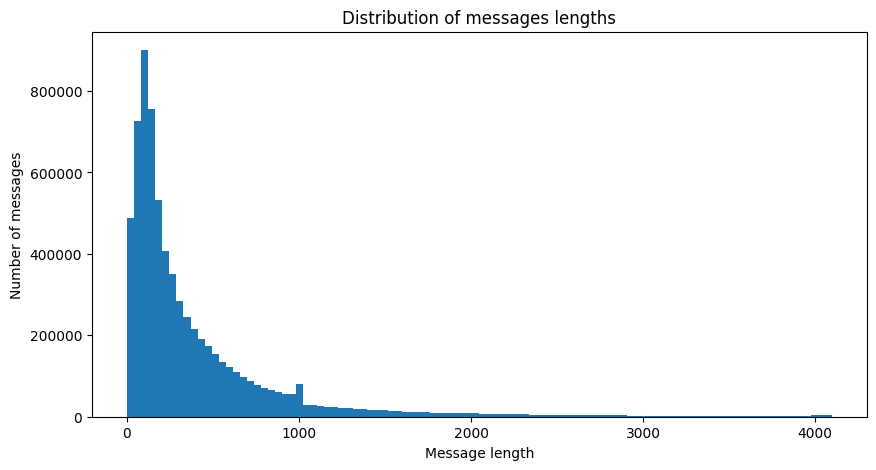

In [14]:
plt.figure(figsize=(10, 5))
df['message'].str.len().plot(kind='hist', bins=100)
plt.title('Distribution of messages lengths')
plt.xlabel('Message length')
plt.ylabel('Number of messages')
plt.show()

# 11. What is this peak at lenght around 1000?

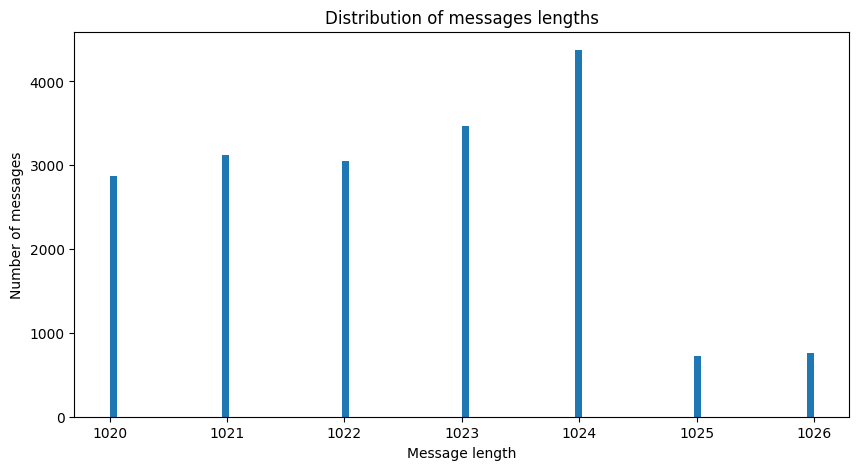

In [15]:
plt.figure(figsize=(10, 5))
df[df['message'].str.len().between(1020, 1026)]['message'].str.len().plot(kind='hist', bins=100)
plt.title('Distribution of messages lengths')
plt.xlabel('Message length')
plt.ylabel('Number of messages')
plt.show() 

In [16]:
df[df['message'].str.len() == 1024]['message'].value_counts().reset_index()

,message,count
0,"«Когда, наконец, покажете свой фильм о Мариуполе?» — непрестанно интересуетесь вы\n\nНе переживайте — кропотливая работа над картиной идет безостановочно, и мы хотим сделать её на качественно новом уровне. Мы уже перелопатили три с половиной терабайта материалов, смонтировали черновую «рыбу» на девять часов и пришли к выводу, что получается не просто фильм, а целый сериал из трех частей.\n\nА пока что собрали, специально для вас, короткую нарезку из нескольких ярких эпизодов. В рамках битвы за Мариуполь, два взятых здания – лишь мгновение.\n\nПредлагаем взглянуть на это глазами штурмовиков батальона «Сомали» и узнать цену каждого такого мгновения. Здесь и сейчас вы увидите войну такой, какова она есть. И поймете, почему русских в Мариуполе действительно ждали.\n\nP.s. Вы можете внести вклад в создание фильма, оказав поддержку, в которой мы по-прежнему очень нуждаемся — как для завершения постпродакшена, так и для новых съемок:\n\nСБ: 5228600720410481 (Сергей)\nТ-ф: 5536913836868766 (Дмитрий)\n\nYouTube / ВК - подпишитесь!",11
1,"Битва за Мариуполь: взгляд изнутри (тизер)\n\nМарт 2022. Отдан приказ на взятие Мариуполя. Батальон «Сомали» в числе основных сил отправлен на штурм укрепленного города. На подступах к Мариуполю еще никто не знал, какой масштаб катастрофы развернется в городе в ближайшие недели, кто из бойцов останется в живых, и какие испытания придется пройти солдатам и мирным жителям.\n\nВ течении двух месяцев тяжелых боев личный состав штурмовой группы «Воробья» зачищает дом за домом, улицу за улицей, вытесняя численно превосходящего противника к Азовстали. Вместе с «сомалийцами», на острие атак, этот путь прошел и Максим Фадеев. Проведя более четырех недель в самом пекле штурма - он стал свидетелем и хроникёром уникальных событий, драматичных сцен, трагедий и побед, которые детально отражены в новом фильме «У края бездны». \n\nНа YouTube в 4К\n\nP.S. Мы очень нуждаемся в вашей поддержке — впереди большая работа по подготовке фильма к выходу на экран и новые съемки.\n\nСбер: 5228600720410481 (Сергей)\nТ-ф: 5536913836868766 (Дмитрий)",10
2,"В четверг посетил Луганскую Народную Республику, где встретился с главами ЛНР Леонидом Пасечником и ДНР Денисом Пушилиным.\n\nПо поручению Президента РФ провёл совещание, посвящённое первоочередным мерам обеспечения безопасности республик Донбасса.\n\nНа совещании, в котором приняли участие генеральный прокурор РФ Игорь Краснов, первый заместитель руководителя Администрации президента РФ Сергей Кириенко, глава МВД Владимир Колокольцев, глава Минстроя Ирек Файзуллин, директор ФСБ Александр Бортников, глава Следственного комитета Александр Бастрыкин, рассмотрели и вопросы содействия экономическому и социальному развитию ЛНР и ДНР.\nОсобое внимание уделили гармонизации законодательств ЛНР и ДНР с законодательством РФ, восстановлению инфраструктуры, вопросам ремонта больниц и подготовки школ к началу учебного года, решению социальных проблем и поддержке граждан.\nГлава СК проинформировал о ходе расследования преступлений, совершённых украинскими националистами, и сборе доказательств в рамках возбуждённых уголовных дел.",10
3,"‼️ВАЖНО: Иностранные спецслужбы создают ТГ-каналы для сетевой войны с Россией\nМногим «военным» каналам предлагают за деньги рекламировать вражеский ТГ-канал «СЕКРЕТАРША ШОЙГУ», где открыто оправдывают терроризм, называют военных боевиками, армия пишут в кавычках, дискредитируют всех силовиков: ВС РФ, ФСБ, МВД, Росгвардию.\nНесмотря на это ряд админов согласились рекламировать явных врагов. \nВероятно канал «СШ» создан ЦИПСО ВСУ:\nПримеры грубой и тупой пропаганды:\n🔹«""Армию"" пополняют за счет осужденных: Власти РФ предлагают осужденным альтернативу в виде ""службы по контракту"". Боевикам поднимут зарплаты, чтобы привлечь новобранцев». \n🔹Про террориста: «В России на двух силовиков осмелился напасть местный подросток»\nСтражи порядка не раздумывая начали стрелять на поражение … 2 правоохранителя не смогли бы задержать одного мальчика? Они пр

In [17]:
print(f"There are {df[df['message'].str.len() == 1024]['message'].nunique()} unique messages of length 1024")

There are 3490 unique messages of length 1024


# 12. What are most popular types of messages?


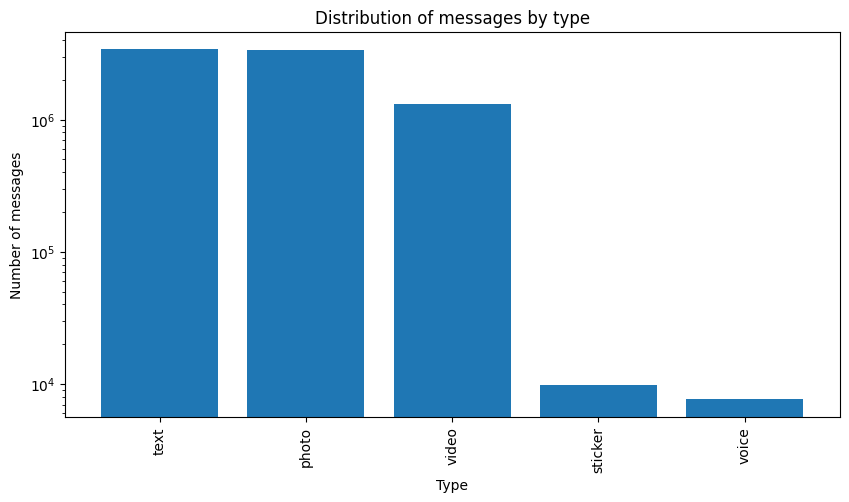

In [18]:
plt.figure(figsize=(10, 5))
df['type'].value_counts().plot(kind='bar', width=0.8)
plt.title('Distribution of messages by type')
plt.xlabel('Type')
plt.ylabel('Number of messages')
plt.yscale('log')
plt.show()

# 13. What is the distribution of video durations

Top 25 longest videos ("outliers"):
          duration
2002832  1511828.0
2161333  1511828.0
1205177    30049.0
6580462    20151.0
4313540    17760.0
6579670    16699.0
6578111    16699.0
1207671    16255.0
1203261    15564.0
4307844    13372.0
7681156    13372.0
6235093    13124.0
999142     12925.0
6049011    12815.0
1357521    12815.0
1357074    12815.0
6580683    11833.0
6576604    11545.0
1297569    11332.0
5856072    11332.0
1637309    11332.0
4971278    10463.0
6050706    10080.0
6050496     9389.0
425552      9280.0


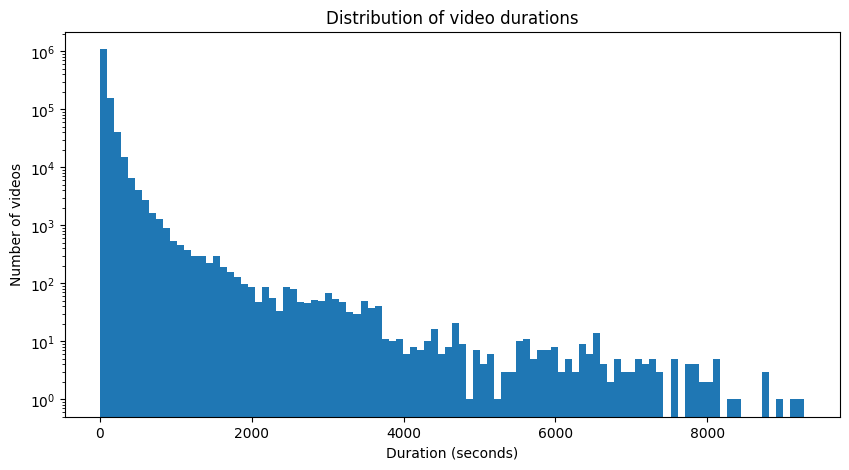

In [19]:
n_outliers = 25
df_ = df[['duration']].dropna().sort_values('duration', ascending=False)
print(f'Top {n_outliers} longest videos ("outliers"):')
print(df_[:n_outliers])

plt.figure(figsize=(10, 5))
df_[n_outliers:]['duration'].plot(kind='hist', bins=100)
plt.title('Distribution of video durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of videos')
plt.yscale('log')
plt.show()

# 14. What is the distribution of the number of reactions per post? Do certain message types receive more reactions?

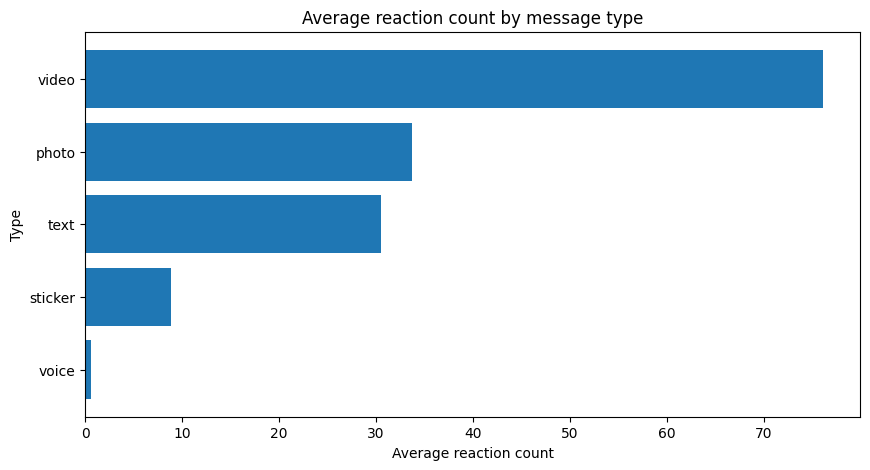

In [20]:
df_ = df.sample(frac=SAMPLE_FRAC)[['type', 'reactions']]
df_ = add_emoji_columns(df_)
df_['reaction_count'] = df_.iloc[:, 15:].sum(axis=1)

plt.figure(figsize=(10, 5))
df_.groupby('type')['reaction_count'].mean().sort_values(ascending=True).plot(kind='barh', width=0.8)
plt.title('Average reaction count by message type')
plt.xlabel('Average reaction count')
plt.ylabel('Type')
plt.show()

# 15. Is there a significant difference in the average views between forwarded and original messages?

Average views - Original messages: 59531.70, Forwarded messages: 27958.56


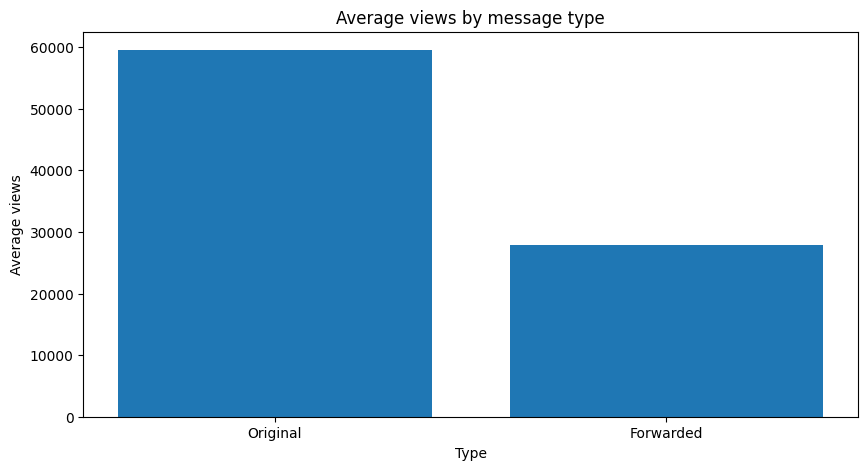

In [21]:
df_ = df.sample(frac=SAMPLE_FRAC)[['fwd_from', 'views']]
original_views = df_[df_['fwd_from'].isna()]['views']
forwarded_views = df_[df_['fwd_from'].notna()]['views']
avg_original_views = original_views.mean()
avg_forwarded_views = forwarded_views.mean()
print(f"Average views - Original messages: {avg_original_views:.2f}, Forwarded messages: {avg_forwarded_views:.2f}")

plt.figure(figsize=(10, 5))
plt.bar(['Original', 'Forwarded'], [avg_original_views, avg_forwarded_views])
plt.title('Average views by message type')
plt.xlabel('Type')
plt.ylabel('Average views')
plt.show()

# 16. Do messages with more reactions also tend to have more views, and how strong is the correlation?

In [22]:
df_ = df.sample(frac=SAMPLE_FRAC)[['views', 'reactions']]
df_ = add_emoji_columns(df_)
df_['reaction_count'] = df_.iloc[:, 3:].sum(axis=1)
correlation_reactions_views = df_['reaction_count'].corr(df_['views'])
print(f"Correlation between the number of reactions and views: {correlation_reactions_views:.2f}")

Correlation between the number of reactions and views: 0.45


# 17. What is the average sentiment of text messages for the top 10 most active channels?

In [23]:
df_ = df[['to_id', 'message']].copy()
top_channels = df_['to_id'].value_counts().head(10).index
top_channel_messages = df_[df_['to_id'].isin(top_channels)]
top_channel_messages['sentiment'] = top_channel_messages['message'].dropna().sample(frac=SAMPLE_FRAC).apply(lambda x: TextBlob(x).sentiment.polarity)
average_sentiment = top_channel_messages.groupby('to_id')['sentiment'].mean()
print("Average sentiment of messages for top 10 most active channels:\n", average_sentiment)

Average sentiment of messages for top 10 most active channels:
 to_id
1003698528    0.000525
1036362176    0.001887
1050820672    0.000718
1082084045    0.004861
1101170442    0.000916
1144180066    0.000720
1310493808    0.003002
1315735637    0.011948
1394050290    0.000748
1408386294    0.001406
Name: sentiment, dtype: float64


/var/folders/16/2kmt14y56rqd2xkgkp53tr080000gn/T/ipykernel_52113/745869127.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_channel_messages['sentiment'] = top_channel_messages['message'].dropna().sample(frac=SAMPLE_FRAC).apply(lambda x: TextBlob(x).sentiment.polarity)


# 18. Are there any outlier channels that have significantly higher average views per message compared to the rest?

In [24]:
df_ = df[['views', 'to_id']]
avg_views_per_channel = df_.groupby('to_id')['views'].mean()
mean_avg_views = avg_views_per_channel.mean()
std_avg_views = avg_views_per_channel.std()
outliers = avg_views_per_channel[avg_views_per_channel > (mean_avg_views + 2 * std_avg_views)]
print("Outlier channels with significantly higher average views:\n", outliers)

Outlier channels with significantly higher average views:
 to_id
1117628569    3.932777e+05
1141171940    8.033314e+05
1210987817    4.172039e+05
1231519967    3.854694e+05
1254661214    4.006779e+05
1288236400    4.596547e+05
1351029634    9.781230e+05
1355540894    3.831089e+05
1425996700    5.566228e+05
1572748754    1.603468e+06
1595839251    3.855857e+05
1685469780    4.361352e+05
Name: views, dtype: float64


# 19. What are the top 10 most frequent words?

In [25]:
top_n = 50

all_messages = " ".join(df['message'].dropna().sample(frac=0.01).to_list())
cleaned_messages = re.sub(r"[^\w\s]", "", all_messages)
cleaned_messages = re.sub(r"\d+", "", cleaned_messages) 
words = [word.strip(string.punctuation) for word in cleaned_messages.lower().split()]
stop_words = set(stopwords.words('english')) | set(stopwords.words('russian'))
filtered_words = [word for word in words if word not in stop_words]
word_counts = Counter(filtered_words)
top_words = word_counts.most_common(top_n)

print(f"Top {top_n} most common words:")
for word, count in top_words:
    print(f"{word}: {count}")

Top 50 most common words:
это: 20523
россии: 13023
рф: 6284
года: 6135
сша: 6114
которые: 5542
также: 5506
время: 4925
который: 4568
области: 4135
украины: 4133
лет: 4068
человек: 4031
сегодня: 3972
заявил: 3822
очень: 3723
году: 3698
россия: 3567
будут: 3509
изза: 3442
путин: 3398
против: 3224
страны: 3117
просто: 3087
украине: 3058
пока: 3029
власти: 3024
ещё: 2789
людей: 2774
рублей: 2733
всё: 2673
москве: 2650
глава: 2627
люди: 2524
область: 2497
видео: 2453
могут: 2445
всу: 2400
день: 2290
несколько: 2251
млн: 2239
президента: 2181
сообщил: 2145
дело: 2106
ранее: 2103
которая: 2101
российских: 2073
нам: 2052
сми: 2037
президент: 2025


# 20. How does the frequency of certain keywords change over time?

/var/folders/16/2kmt14y56rqd2xkgkp53tr080000gn/T/ipykernel_52113/1283708788.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  keyword_over_time = df_.groupby(df_['date_time'].dt.to_period('M'))[f'{keyword}_count'].sum()


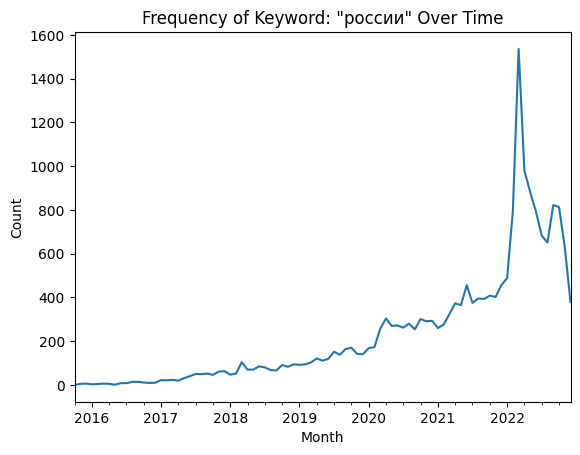

/var/folders/16/2kmt14y56rqd2xkgkp53tr080000gn/T/ipykernel_52113/1283708788.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  keyword_over_time = df_.groupby(df_['date_time'].dt.to_period('M'))[f'{keyword}_count'].sum()


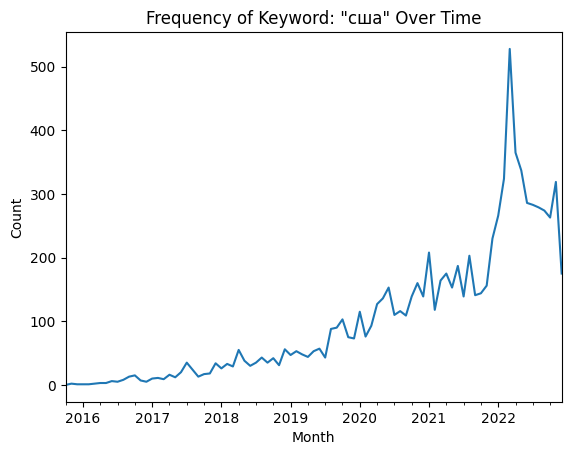

/var/folders/16/2kmt14y56rqd2xkgkp53tr080000gn/T/ipykernel_52113/1283708788.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  keyword_over_time = df_.groupby(df_['date_time'].dt.to_period('M'))[f'{keyword}_count'].sum()


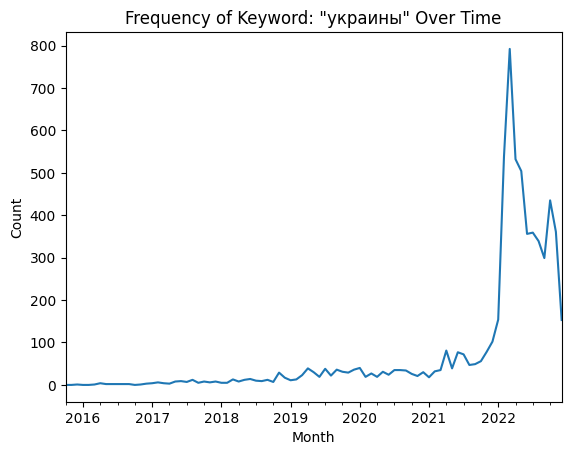

In [26]:
df_ = df[['message', 'date_time']].sample(frac=SAMPLE_FRAC).copy()
keywords = ["россии", "сша", "украины"]
for keyword in keywords:
    df_[f'{keyword}_count'] = df_['message'].str.lower().str.contains(keyword, na=False)
    keyword_over_time = df_.groupby(df_['date_time'].dt.to_period('M'))[f'{keyword}_count'].sum()
    keyword_over_time.plot(kind='line', title=f'Frequency of Keyword: "{keyword}" Over Time', xlabel='Month', ylabel='Count')
    plt.show()

# 21. How often users write russian and Ukraine related words in lowercase?

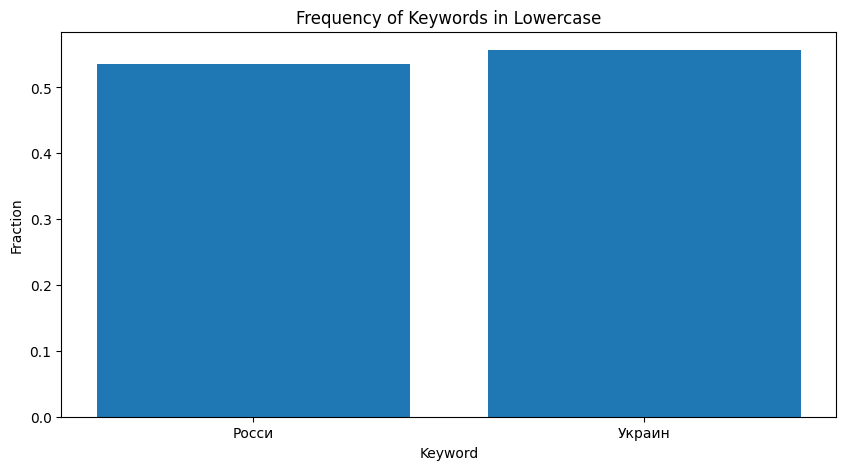

In [27]:
df_ = df[['message']].sample(frac=SAMPLE_FRAC).copy()
keywords = ["Росси", "Украин"]
frequency = {}
for keyword in keywords:
    keyword_count = df_['message'].str.contains(keyword, na=False).sum()
    lower_keyword_count = df_['message'].str.contains(keyword.lower(), na=False).sum()
    fraction = lower_keyword_count / keyword_count
    frequency[keyword] = fraction
    
plt.figure(figsize=(10, 5))
plt.bar(frequency.keys(), frequency.values())
plt.title('Frequency of Keywords in Lowercase')
plt.xlabel('Keyword')
plt.ylabel('Fraction')
plt.show()

# 22. Are channels that post more frequently also more likely to have higher average views?

In [28]:
df_ = df[['to_id', 'views']].copy()
message_counts = df_['to_id'].value_counts()
avg_views_per_channel = df_.groupby('to_id')['views'].mean()
correlation_frequency_views = pd.concat([message_counts, avg_views_per_channel], axis=1).corr().iloc[0, 1]
print(f"Correlation between posting frequency and average views: {correlation_frequency_views:.2f}")

Correlation between posting frequency and average views: -0.11


# 23. What are the channels with least variation of views?

In [29]:
channel_message_counts = df_['to_id'].value_counts()
valid_channels = channel_message_counts[channel_message_counts >= 50].index
df_ = df_[df_['to_id'].isin(valid_channels)]
views_std_per_channel = df_.groupby('to_id')['views'].std()
consistent_channels = views_std_per_channel.nsmallest(50)
print("Channels with the most consistent engagement levels (least variation in views):\n", consistent_channels)


Channels with the most consistent engagement levels (least variation in views):
 to_id
1249511529        0.000000
1315357774        0.000000
1335874190        0.000000
1366415996        0.000000
1472933118        0.000000
1498012303        0.000000
1661202164        0.000000
1679205140        0.000000
1679897217        0.000000
1285350880     1642.000125
1130857940     2603.117908
1007396605     2913.439852
1035235678     3229.099798
1324086929     4277.773752
1100300699     4878.636449
1170178502     5071.389629
1310493808     5745.896732
1277550597     5925.281481
1178051064     5966.562886
1104303314     6059.726564
1207840909     6106.543513
1242933179     6226.038280
1064580781     6260.131578
1294395501     6294.187157
1120151877     6324.036645
1071040207     6587.870246
1030852584     6816.103772
1685944197     7047.863795
1118679396     7137.859819
1433731512     7219.819148
1122103071     7537.541387
1418299591     7622.243314
1144015339     8730.490175
1082084045     8887.18

# 24. What are the groups with highest views-to-reactions correlation?

In [30]:
def calculate_correlation(group):
    if len(group) < 2 or group['views'].std() == 0 or group['reaction_count'].std() == 0:
        return np.nan
    return group['views'].corr(group['reaction_count'])

df_ = df[['to_id', 'views', 'reactions']].dropna().sample(frac=SAMPLE_FRAC).copy()
df_ = add_emoji_columns(df_)
df_['reaction_count'] = df_.iloc[:, 4:].sum(axis=1)

group_stats = (
    df_.groupby('to_id')
       .apply(lambda group: pd.Series({
           'correlation': calculate_correlation(group.reset_index(drop=True)),
           'sampled_message_count': len(group)
       }))
)

group_stats['approx_true_message_count'] = (group_stats['sampled_message_count'] / SAMPLE_FRAC).astype(int)
filtered_stats = group_stats[group_stats['sampled_message_count'] >= 100]

top_correlated_groups = (
    filtered_stats.dropna(subset=['correlation'])
                  .sort_values(by='correlation', ascending=False)
                  .head(10)
)

top_correlated_groups

/var/folders/16/2kmt14y56rqd2xkgkp53tr080000gn/T/ipykernel_52113/2707503713.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.Series({


,correlation,sampled_message_count,approx_true_message_count
to_id,,,
1106998917,0.726703,111.0,5550
1100158992,0.705965,324.0,16200
1168636470,0.699202,157.0,7850
1291701327,0.662506,148.0,7400
1124038902,0.660514,186.0,9300
1109403194,0.643823,199.0,9950
1146075551,0.642970,177.0,8850
1093357968,0.608974,111.0,5550
1126914293,0.608875,290.0,14500


# 25. What is the average reaction-to-view ratio per post?

In [31]:
df_ = df[['views', 'reactions']].sample(frac=SAMPLE_FRAC).copy()
df_ = add_emoji_columns(df_)
df_['reaction_count'] = df_.iloc[:, 3:].sum(axis=1)
df_['reaction_to_view_ratio'] = df_['reaction_count'] / df_['views']
df_ = df_[np.isfinite(df_['reaction_to_view_ratio'])]
average_ratio = df_['reaction_to_view_ratio'].mean()
print(f"Average reaction-to-view ratio: {average_ratio:.4f}")

Average reaction-to-view ratio: 0.0038


# 26. What is the average duration of video content per channel?

In [32]:
df_ = df[['to_id', 'duration']].copy()
video_duration_per_channel = df_.dropna().groupby('to_id')['duration'].mean().sort_values(ascending=False).head(10)

print("Top 10 channels by average video duration:")
print(video_duration_per_channel)


Top 10 channels by average video duration:
to_id
1124474503    1798.732910
1407902266    1481.706299
1054569797     822.446960
1472186202     683.283813
1391554172     381.206604
1409792267     348.077423
1436234144     343.652618
1578167821     318.846161
1065276858     301.777222
1101566189     267.315796
Name: duration, dtype: float32


# 27. What are the most common topics in highly viewed posts?

In [33]:
english_stopwords = set(stopwords.words('english'))
russian_stopwords = set(stopwords.words('russian'))
all_stopwords = english_stopwords.union(russian_stopwords)

df_ = df[['message', 'views']].copy()
high_view_posts = df_[df_['views'] > df_['views'].mean()]
all_text = " ".join(high_view_posts['message'].dropna())
cleaned_text = re.sub(r'[^\w\s]', '', all_text.lower())
cleaned_text = re.sub(r'\d+', '', cleaned_text)
cleaned_text = " ".join(
    word for word in cleaned_text.split() if word not in all_stopwords
)

word_counts = Counter(cleaned_text.split())
word_counts_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])

print("Most common topics in highly viewed posts:")
print(word_counts_df)

Most common topics in highly viewed posts:
       Word   Count
0       это  414185
1    россии  328368
2        рф  188475
3     также  148437
4   украины  148352
5       сша  135103
6   которые  129173
7   области  127937
8       всу  125051
9   украине  121645
10     года  116587
11    время  114261
12   заявил  108140
13  который   95574
14  сегодня   91939
15  человек   91283
16   россия   88683
17      лет   84379
18     изза   83220
19    будут   82113


# 28. In which proportion different languages are used?

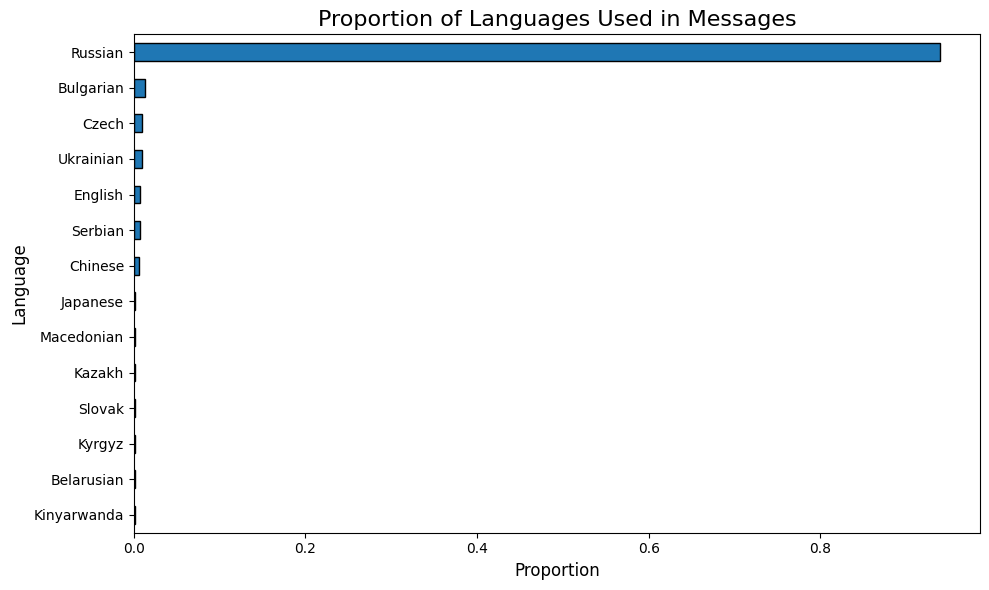

In [34]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

df_ = df[['message']].dropna().sample(1000).copy()

def detect_language(text):
    try:
        lang, prob = identifier.classify(text)
        return lang
    except Exception:
        return "unknown"

df_['language'] = df_['message'].apply(detect_language)

threshold = 0.001  # Threshold for less frequent languages
language_counts = df_['language'].value_counts(normalize=True)
frequent_languages = language_counts[language_counts >= threshold]
other_languages = language_counts[language_counts < threshold].sum()
if other_languages > 0:
    frequent_languages['Others'] = other_languages

def get_language_name(code):
    try:
        return langcodes.get(code).language_name()
    except LookupError:
        return code

frequent_languages.index = [get_language_name(lang) for lang in frequent_languages.index]

plt.figure(figsize=(10, 6))
frequent_languages.sort_values().plot(
    kind='barh',
    colormap='tab10',
    edgecolor='black'
)

plt.title('Proportion of Languages Used in Messages', fontsize=16)
plt.xlabel('Proportion', fontsize=12)
plt.ylabel('Language', fontsize=12)
plt.tight_layout()
plt.show()

# 29. Which type of message is most frequently forwarded?

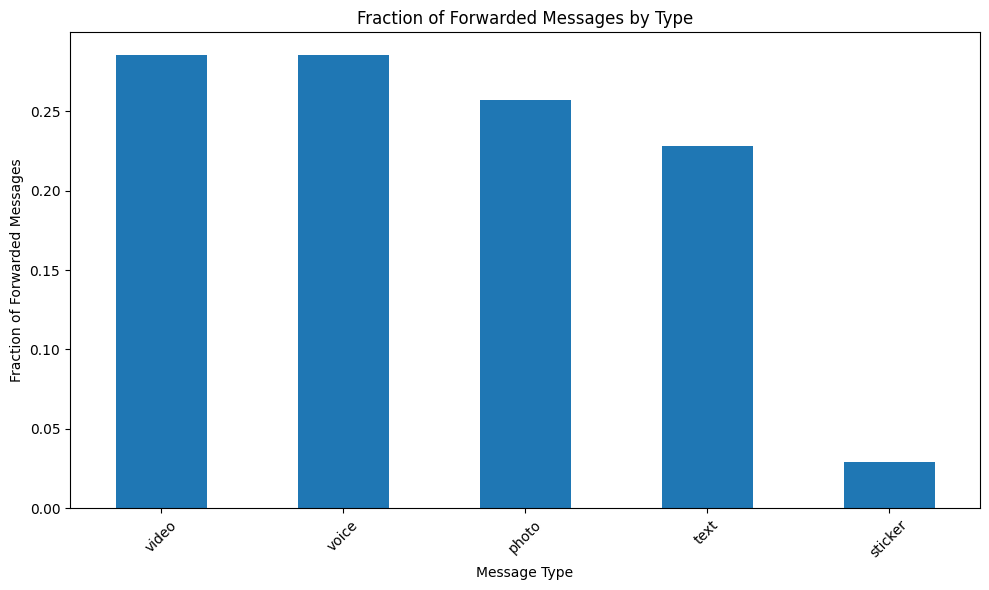

In [35]:
df_ = df[['type', 'fwd_from']].copy()

df_['is_forwarded'] = df_['fwd_from'].notna()

forwarded_fraction_by_type = df_.groupby('type')['is_forwarded'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
forwarded_fraction_by_type.plot(kind='bar')
plt.title('Fraction of Forwarded Messages by Type')
plt.xlabel('Message Type')
plt.ylabel('Fraction of Forwarded Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 30. Which keywords are associated with high-reaction posts?

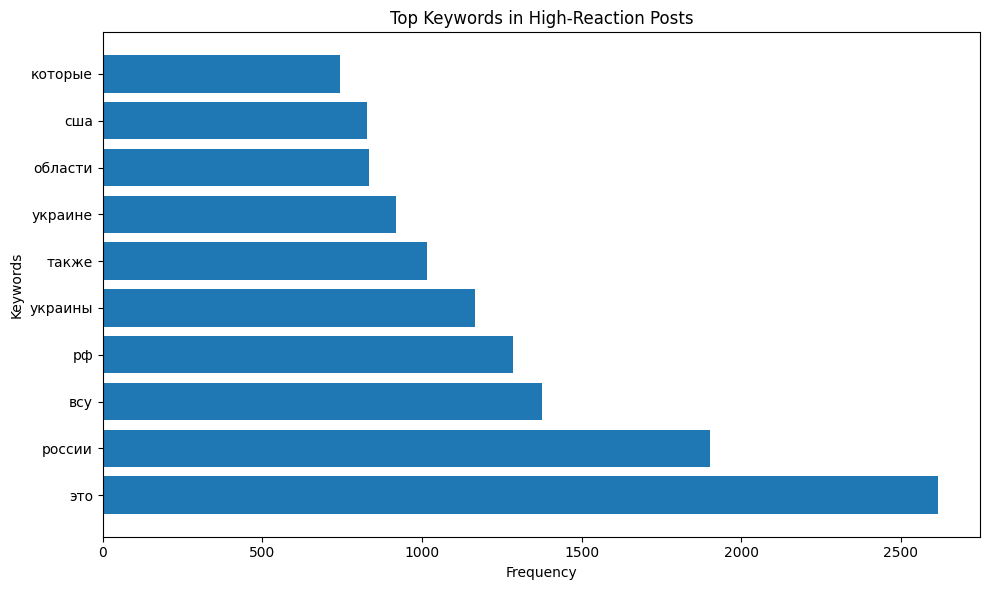

In [36]:
df_ = df[['message', 'reactions']].dropna().sample(frac=SAMPLE_FRAC).copy()
df_ = add_emoji_columns(df_)
df_['reaction_count'] = df_.iloc[:, 3:].sum(axis=1)

high_reaction_posts = df_[df_['reaction_count'] > df_['reaction_count'].mean()]

all_messages = " ".join(high_reaction_posts['message'].dropna())

cleaned_text = re.sub(r'[^\w\s]', '', all_messages.lower())
words = cleaned_text.split()

stop_words = set(stopwords.words('english')) | set(stopwords.words('russian'))
filtered_words = [word for word in words if word not in stop_words]

word_counts = Counter(filtered_words)
top_keywords = word_counts.most_common(10)

keywords, counts = zip(*top_keywords)

plt.figure(figsize=(10, 6))
plt.barh(keywords, counts)
plt.title('Top Keywords in High-Reaction Posts')
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.tight_layout()
plt.show()